# Projet Kaggle

## Prérequis

In [1]:
import numpy as np
import os
from pathlib import Path
import random

from sklearn.decomposition import PCA
from sklearn import metrics
import imagesize
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image, ImageOps

from tensorflow import keras
from tensorflow.keras import layers
from keras.preprocessing.image import ImageDataGenerator



* Aller voir utilité de faire une ACP sur des images

* Faire un df contenant tout (cf code de Béné)
* Séparer en 2 df train et test
* Faire analyse des données (ACP, chi 2...?)
* Shuffle le train pour éviter d'avoir tout les NORMAL ensemble (le test aussi ?)
* Créer un DataGenerator par flow_from_directory() (cf https://studymachinelearning.com/keras-imagedatagenerator-with-flow_from_directory/)
* Faire data augmentation à partir du DataGenerator





Pour avoir accès aux données que j'ai stockées sur le drive : \
(il faut saisir un code google pour activer)

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!apt-get install tree

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 37 not upgraded.
Need to get 40.7 kB of archives.
After this operation, 105 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tree amd64 1.7.0-5 [40.7 kB]
Fetched 40.7 kB in 0s (781 kB/s)
Selecting previously unselected package tree.
(Reading database ... 155047 files and directories currently installed.)
Preparing to unpack .../tree_1.7.0-5_amd64.deb ...
Unpacking tree (1.7.0-5) ...
Setting up tree (1.7.0-5) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


## Exploration des données

*A faire avec l'architecture originale des dossiers*

In [ ]:
data_dir_ori = '/content/drive/MyDrive/Kaggle/chest_xray_original/'

In [ ]:
!tree -d /content/drive/MyDrive/Kaggle/chest_xray_original/

On crée un dataframe contenant toutes les données et metadonnées.

In [ ]:
datasets = os.listdir(data_dir_ori)
print(datasets)
subfolders = sorted(os.listdir(os.fspath(data_dir_ori + datasets[0])))
print(subfolders)

for i in range(1, 3):
  assert subfolders == sorted(os.listdir(os.fspath(data_dir_ori + datasets[i])))

['val', 'test', 'train']
['NORMAL', 'PNEUMONIA']


In [ ]:
metadata = []

for dataset in datasets:
    for subfolder in subfolders:
        folder_path = os.path.join(data_dir_ori, dataset, subfolder)
        all_files = os.listdir(folder_path)
        for each_file in all_files:
            its_path = os.path.join(folder_path, each_file)
            its_name = each_file.split(".")[0]
            metadata.append([dataset, subfolder, its_name, its_path])

for line in metadata[:5]:
  print(line)

['val', 'NORMAL', 'NORMAL2-IM-1430-0001', '/content/drive/MyDrive/Kaggle/chest_xray_original/val/NORMAL/NORMAL2-IM-1430-0001.jpeg']
['val', 'NORMAL', 'NORMAL2-IM-1431-0001', '/content/drive/MyDrive/Kaggle/chest_xray_original/val/NORMAL/NORMAL2-IM-1431-0001.jpeg']
['val', 'NORMAL', 'NORMAL2-IM-1427-0001', '/content/drive/MyDrive/Kaggle/chest_xray_original/val/NORMAL/NORMAL2-IM-1427-0001.jpeg']
['val', 'NORMAL', 'NORMAL2-IM-1442-0001', '/content/drive/MyDrive/Kaggle/chest_xray_original/val/NORMAL/NORMAL2-IM-1442-0001.jpeg']
['val', 'NORMAL', 'NORMAL2-IM-1438-0001', '/content/drive/MyDrive/Kaggle/chest_xray_original/val/NORMAL/NORMAL2-IM-1438-0001.jpeg']


In [ ]:
columns = ["subset", "class_str", "name", "path"]
df = pd.DataFrame(metadata, columns=columns)
df.head()

,subset,class_str,name,path
0,val,NORMAL,NORMAL2-IM-1430-0001,/content/drive/MyDrive/Kaggle/chest_xray_origi...
1,val,NORMAL,NORMAL2-IM-1431-0001,/content/drive/MyDrive/Kaggle/chest_xray_origi...
2,val,NORMAL,NORMAL2-IM-1427-0001,/content/drive/MyDrive/Kaggle/chest_xray_origi...
3,val,NORMAL,NORMAL2-IM-1442-0001,/content/drive/MyDrive/Kaggle/chest_xray_origi...
4,val,NORMAL,NORMAL2-IM-1438-0001,/content/drive/MyDrive/Kaggle/chest_xray_origi...


In [ ]:
print('Jeux de données :')
print(df['subset'].value_counts())
print()
print('Classes :')
print(df['class_str'].value_counts())
print()
print('Matrice de comptage :')
print(pd.crosstab(df.subset, df.class_str))
print()
print(f"Nombre total d'images : {df.shape[0]}")

Le set `train` est très déséquilibré en faveur de `PNEUMONIA`, le set `test` est un peu déséquilibré en faveur de `PNEUMONIA` et le set `val` est parfaitement équilibré.

*Faire un truc graphique pour montrer la répartition de manière visuelle : histo, camembert...*

### Format des images

Identification de l'extension des fichiers :

In [ ]:
def get_suffix(file_path):
  return Path(file_path).suffix

suffixes = set(df['path'].map(get_suffix))
print(f'Extensions : {suffixes}')

Répartition des dimensions des 500 premières images, sans charger les images en mémoire (cf [imagesize](https://pypi.org/project/imagesize/)) :

In [ ]:
def get_dimensions(file_path):
  return imagesize.get(file_path)[0], imagesize.get(file_path)[1]

dimensions = df['path'][:500].map(get_dimensions)

In [ ]:
widths = [width for width, height in dimensions]
heights = [height for width, height in dimensions]
ratios =  [round(width / height, 2) for width, height in dimensions]
print(f"Nombre de largeurs d'image différentes : {len(set(widths))}")
print(f"Nombre de hauteurs d'image différentes : {len(set(heights))}")
print(f"Nombre de ratios différents : {len(set(ratios))}")

In [ ]:
plt.rcParams['figure.figsize'] = 15, 5
plt.style.use('seaborn-whitegrid')

fig, ax = plt.subplots(1, 3)

ax[0].hist(widths, bins=20, facecolor = '#2ab0ff', edgecolor='#169acf')
ax[0].set_title('Histogramme des largeurs')
ax[0].set_xlabel('Largeur (pixels)') 

ax[1].hist(heights, bins=20, facecolor = '#2ab0ff', edgecolor='#169acf',)
ax[1].set_title('Histogramme des hauteurs')
ax[1].set_xlabel('Hauteur (pixels') 

ax[2].hist(ratios, bins=20, facecolor = '#2ab0ff', edgecolor='#169acf',)
ax[2].set_title('Histogramme des ratios')
ax[2].set_xlabel('Largeur sur hauteur (pixels)') 

plt.show()

Les dimensions des images sont donc très variées, ainsi que leur ratio. 

Sous  certaines conditions, il est aujourd'hui possible d'utiliser des CNNs sur des images de tailles différentes et/ou de ratio non égal à 1. Dans un premier temps et par souci de simplicité nous allons cependant redimensionner toutes les images à la même taille avec un ratio 1:1.

Exploration du redimensionnement des images :

In [ ]:
test_index = [np.argmin(ratios), ratios.index(1), ratios.index(1.5), np.argmax(ratios)]
test_imgs = [Image.open(df['path'][i]) for i in test_index]

In [ ]:
sizes = [(256, 256), (128, 128), (96, 96), (64, 64), (32, 32)]

plt.style.use('default')
plt.rcParams['figure.figsize'] = 15, 3.5

fig, ax = plt.subplots(1, 4)
fig.suptitle('Sans redimensionnement')
for i, img in enumerate(test_imgs):
  ax[i].xaxis.set_ticks_position('top')
  ax[i].imshow(img, cmap=plt.get_cmap('gray'))
  ax[i].xaxis.set_ticks_position('top')
plt.show()

for new_size in sizes:
  fig, ax = plt.subplots(1, 4)
  fig.suptitle(f'Redimensionnement {new_size}')
  for i, img in enumerate(test_imgs):
    ax[i].xaxis.set_ticks_position('top')
    ax[i].imshow(img.resize(new_size), cmap=plt.get_cmap('gray'))
  plt.show()

Les images redimensionnées en (64, 64) commencent à perdre trop d'informations. On sélectionne donc la taille (96, 96) en première approche.

## Un premier réseau : ACP et réseau dense

Ici l'idée est d'effectuer une ACP sur les images afin d'en réduire le nombre de caractéristiques et par conséquent réduire le nombre de paramètres du réseau.

### Chargement des données

Pour effectuer une ACP, il est nécessaire charger toutes les images en mémoire. On va de plus travailler sur des images peu réduites en taille afin de partir avec le maximum d'information.


In [ ]:
# Shuffle des lignes du df pour éviter tout biais.
df = df.sample(frac=1).reset_index(drop=True)
df.head()

NameError: ignored

In [ ]:
df_train = df.loc[(df['subset'] == 'train') | (df['subset'] == 'val')]
df_train.shape

(5232, 4)

In [ ]:
%timeit

# ça a pris 1/4 d'heure...

img_size = (500, 500)
x_train = np.zeros((df_train.shape[0], *img_size), dtype=np.float32)

for i_np, (i_row, row) in enumerate(df_train.iterrows()):
    img = Image.open(row['path'])
    img = ImageOps.grayscale(img).resize(img_size)
    img = np.asarray(img)
    x_train[i_np, :, :] = img

x_train /= 255  # Normalisation.

On vérifie que les images ont bien été chargées correctement :

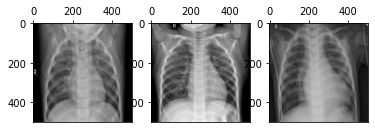

In [ ]:
fig, ax = plt.subplots(1, 3)
for i, i_np in enumerate(random.sample(range(0, df_train.shape[0]), 3)):
    ax[i].xaxis.set_ticks_position('top')
    ax[i].imshow(x_train[i_np], cmap='gray')   
plt.show()

Il faut maintenant applatir chacune des images avant de pouvoir faire une ACP.

In [ ]:
y_train = pd.Categorical(df_train.class_str).codes

image 2D
Normaliser


## CNN

In [3]:
data_dir = '/content/drive/MyDrive/Kaggle/chest_xray/'

In [ ]:
!tree -d /content/drive/MyDrive/Kaggle/chest_xray/

/content/drive/MyDrive/Kaggle/chest_xray/
├── test
└── train
    ├── NORMAL
    └── PNEUMONIA

4 directories


In [4]:
path_train = data_dir + 'train/'
path_test = data_dir + 'test/'

### RESNET sans data augmentation

Création des ImageDataGenerators.

In [5]:
batch_size = 32
num_classes = 2

In [6]:
train_datagen = ImageDataGenerator(samplewise_center=True,  # Centrage des images
                                   samplewise_std_normalization=True, # Normalisation
                                   rescale=1./255,
                                   dtype=np.float32,
                                   validation_split=0.2)

test_datagen = ImageDataGenerator(rescale=1./255)

In [14]:
train_generator = train_datagen.flow_from_directory(directory=path_train,
                                                    target_size=(96, 96),
                                                    color_mode='rgb',
                                                    interpolation='nearest',
                                                    class_mode='binary',
                                                    subset='training',
                                                    batch_size=batch_size,
                                                    shuffle=True,
                                                    seed=55)

val_generator = train_datagen.flow_from_directory(directory=path_train,
                                                  target_size=(96, 96),
                                                  color_mode='rgb',
                                                  interpolation='nearest',
                                                  class_mode='binary',
                                                  subset='validation',
                                                  batch_size=batch_size,
                                                  shuffle=True,
                                                  seed=55)

test_generator = test_datagen.flow_from_directory(directory=path_test,
                                                  target_size=(96, 96),
                                                  color_mode='rgb',
                                                  interpolation='nearest',
                                                  class_mode='binary',
                                                  batch_size=batch_size,
                                                  shuffle=False,
                                                  seed=55)

Found 4187 images belonging to 2 classes.
Found 1045 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [8]:
def plot_cm(cm):
    labels = ['NORMAL', 'PNEUMONIA']
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

In [9]:
def plot_roc_pr(y_test, y_pred):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))   
    
    fp_rate, tp_rate, thresholds_roc = metrics.roc_curve(y_test, y_pred)
    auc_roc = metrics.auc(fp_rate, tp_rate)
    ax[0].plot([0, 1], [0, 1], linestyle='--')
    ax[0].plot(fp_rate, tp_rate, marker='.')
    ax[0].set_title('Courbe ROC')
    ax[0].set_xlabel('Taux de faux positifs')
    ax[0].set_ylabel('Taux de vrais positifs')
    ax[0].legend(['Référence\nAUC : 0.5', f'Modèle\nAUC : {auc_roc:.3f}'], loc='lower right')
    
    precision, recall, thresholds = metrics.precision_recall_curve(y_test, y_pred)
    auc_pr = metrics.average_precision_score(y_test, y_pred)
    ax[1].plot([1, 0], [0, 1], linestyle='--')
    ax[1].plot(recall, precision)
    ax[1].set_title('Courbe PR')
    ax[1].set_xlabel('Recall')
    ax[1].set_ylabel('Precision')
    ax[1].legend(['Référence\nAUC : 0.5', f'Modèle\nAUC : {auc_pr:.3f}'], loc='lower left')    
    
    plt.show()
    return auc_roc, auc_pr

In [10]:
def plot_loss_acc(history):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('Loss du modèle')
    ax[0].set_xlabel('Époque')
    ax[0].set_ylabel('Loss')
    ax[0].legend(['train', 'val'], loc='upper right')

    ax[1].plot(history.history['accuracy'])
    ax[1].plot(history.history['val_accuracy'])
    ax[1].set_title('Accuracy du modèle')
    ax[1].set_xlabel('Époque')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend(['train', 'val'], loc='lower right')
    
    fig.tight_layout()
    plt.show()

In [17]:
cb_early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
cb_reduce_LR = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=3, mode="auto", verbose=1)

Création du réseau.

https://keras.io/api/applications/resnet/

https://keras.io/guides/transfer_learning/

In [30]:
model_resnet = keras.applications.ResNet50V2(include_top=False,
                                             weights='imagenet',
                                             input_shape=(96, 96, 3),
                                             pooling='avg',
                                             classes=2,
                                             classifier_activation='softmax')

# Taking the output of the last convolution block in ResNet50
output_resnet = model_resnet.output
#dense_1 = layers.Dense(1024, activation='relu')(output_resnet)
#output = layers.Dense(1, activation='sigmoid')(x)
predictions = layers.Dense(1, activation='sigmoid')(output_resnet)
 
# Model to be trained
model = keras.Model(inputs=model_resnet.input, outputs=predictions)
 
# Training only top layers i.e. the layers which we have added in the end
for layer in model_resnet.layers:
    layer.trainable = False

# Compiling the model
model.compile(optimizer='nadam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 102, 102, 3)  0           input_6[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 48, 48, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 50, 50, 64)   0           conv1_conv[0][0]                 
____________________________________________________________________________________________

In [31]:
model.fit(train_generator,
          batch_size=batch_size,
          epochs=10,
          verbose=1,
          validation_data=val_generator,
          callbacks=[cb_early_stopping, cb_reduce_LR])

Epoch 1/10
131/131 [==============================] - 197s 1s/step - loss: 0.4481 - accuracy: 0.8099 - val_loss: 0.3194 - val_accuracy: 0.8574
Epoch 2/10
131/131 [==============================] - 159s 1s/step - loss: 0.2508 - accuracy: 0.8997 - val_loss: 0.2873 - val_accuracy: 0.8699
Epoch 3/10
131/131 [==============================] - 159s 1s/step - loss: 0.2194 - accuracy: 0.9102 - val_loss: 0.2883 - val_accuracy: 0.8794
Epoch 4/10
131/131 [==============================] - 159s 1s/step - loss: 0.1916 - accuracy: 0.9219 - val_loss: 0.2500 - val_accuracy: 0.8871
Epoch 5/10
131/131 [==============================] - 158s 1s/step - loss: 0.1777 - accuracy: 0.9269 - val_loss: 0.2470 - val_accuracy: 0.9014
Epoch 6/10
131/131 [==============================] - 159s 1s/step - loss: 0.1636 - accuracy: 0.9324 - val_loss: 0.2396 - val_accuracy: 0.9081
Epoch 7/10
131/131 [==============================] - 159s 1s/step - loss: 0.1510 - accuracy: 0.9398 - val_loss: 0.2290 - val_accuracy: 0.9158

In [20]:
result = model.predict(test_generator)

In [21]:
result.shape

(624, 1)

In [24]:
0 in result

False

In [25]:
loss, acc = model.evaluate(test_generator, verbose=1)
print(loss, acc)

20/20 [==============================] - 19s 881ms/step - loss: 0.8707 - accuracy: 0.6250
0.8707125782966614 0.625


In [ ]:
#Confution Matrix and Classification Report
Y_pred = model.predict_generator(validation_generator, num_of_test_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')
target_names = ['Cats', 'Dogs', 'Horse']
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

In [ ]:
f1 = metrics.f1_score(y_test_1_column, pred_96_1_column)
mcc = metrics.matthews_corrcoef(y_test_1_column, pred_96_1_column)
print(f'MCC: {mcc:.4f} - F1: {f1:.4f}')

# Courbes.
cm = metrics.confusion_matrix(y_test_1_column, pred_96_1_column)
plot_cm(cm)
plot_loss_acc(history1)
auc1 = plot_roc_pr(y_test_1_column, pred_96_2_column[:, 1])

# Bazar, des vieux trucs

In [ ]:
image_size = (180, 180)
batch_size = 64
data_dir = '/content/drive/MyDrive/Kaggle/chest_xray/'

In [ ]:
dataset = kr.preprocessing.image_dataset_from_directory(data_dir, labels='inferred', image_size=image_size, batch_size=batch_size)

In [ ]:
print(type(dataset))
print(dataset.class_names)

`image_dataset_from_directory` infère les classes en fonction de l'architecture des dossiers. Malheureusement les données ne sont pas ici rangées par classe. On va donc charger manuellement les données.

In [ ]:
# Subsets
train_folder = data_dir + 'train/'
test_folder = data_dir + 'test/'
val_folder = data_dir + 'val/'

# Classes
train_n = train_folder + 'NORMAL/'
train_p = train_folder + 'PNEUMONIA/'
test_n = test_folder + 'NORMAL/'
test_p = test_folder + 'PNEUMONIA/'
val_n = val_folder + 'NORMAL/'
val_p = val_folder + 'PNEUMONIA/'

In [ ]:
df['class'] = df['class_str']
df = df[["subset", "class", "class_str", "name", "path"]]
df['class'] = pd.Categorical(df.class_str).codes
df.loc[df['subset'] == 'val']

Est-ce qu'on rajouterait pas une colonne avec le np.array de l'image ?

In [ ]:
def load_images(df, image_size):
  #image = Image.open(img_path)
  #img_resized = image.resize(image_size)
  #data = np.asarray(img_resized)
  df['img'] = np.asarray(Image.open(df['path']).resize(image_size))

On applique la fonction pour chacune des lignes du df.

In [ ]:
img = Image.open(df['path'][639])
print(img.size)

In [ ]:
%timeit

df['img'] = [ImageOps.grayscale(Image.open(img_path).resize(image_size)) for img_path in df['path']]

In [ ]:
df.iloc[:2]

In [ ]:
df = df[["subset", "img", "class", "class_str", "name", "path"]]
df.iloc[:2]

In [ ]:
df['img'] = [np.asarray(img) for img in df['img']]
df.iloc[:2]

Pour parcourir dans un ordre aléatoire toutes les lignes de train :

In [ ]:
train_x = np.zeros((5216, *image_size))
for i_np, i_df in zip(range(5217), np.random.permutation(range(640, 5856))):
  train_x[i_np, :, :] = df['img'][i_df]

In [ ]:
train_x[0]

In [ ]:
for i in range(9):
  plt.subplot(330 + 1 + i)
  plt.imshow(train_x[i], cmap=plt.get_cmap('gray'))
plt.show()

In [ ]:
plt.imshow(train_x[5], cmap='gray')
#plt.show()

https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/

In [ ]:
# create iterator
it = datagen.flow_from_directory(X, y, ...)

Je voudrais voir si les subsets sont bien tous représentatifs de l'ensemble des données. A priori ce ne sera pas le cas à cause des déséquilibres entre subsets.

(faire un chi² ?)

ACP

# 1) J1 : premiers tests (ça c'est les TPs fait en cours hein, je garde juste ça sous la main pour pas galérer à retrouver)

In [ ]:
import tensorflow as tf
import numpy as np

# Ne pas importer keras sans passer par tf, sinon pas les mêmes fonctions
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt

In [ ]:
num_classes = 10

Load and prepare the [MNIST dataset](http://yann.lecun.com/exdb/mnist/). Convert the samples from integers to floating-point numbers:

In [ ]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
#x_train, x_test = x_train / 255.0, x_test / 255.0

In [ ]:
type(x_train)

In [ ]:
x_train.shape

In [ ]:
y_train.shape

In [ ]:
# Plot image
for i in range(9):
  plt.subplot(330 + 1 + i)
  plt.imshow(x_train[i], cmap=plt.get_cmap('gray'))
plt.show()

In [ ]:
# Scale images to the [0, 1] range in 32 bits
# Tensorflow travaille en 32 bits, potentiellement en 64
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

In [ ]:
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

In [ ]:
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")

Limite : limite mémoire vive du PC

In [ ]:
# Convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [ ]:
plt.imshow(x_train[0])
plt.show()

In [ ]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# Scale images to the [0, 1] range in 32 bits
# Tensorflow travaille en 32 bits, potentiellement en 64
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
x_train = np.reshape(x_train, (60000, 784))
x_test = np.reshape(x_test, (10000, 784))

In [ ]:
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")

Avec l'API séquentielle, on stacke des couches mais on ne peut pas récupérer le résultat des différentes couches, mais ac API fonctionnelle on peut nommer les couches et dessiner tout un tas de graphes

In [ ]:
input_shape = (784, )
inputs = keras.Input(shape=input_shape) # on définit la première couche
print(inputs.shape)
print(inputs.dtype)

In [ ]:
# 2 syntaxes
dense = layers.Dense(64, activation="relu")
hidden_1 = dense(inputs)
# Equivalent à :
# hidden_1 = layers.Dense(64, activation="relu")(inputs)

In [ ]:
# ou alors
hidden_2 = layers.Dense(64, activation="relu")(hidden_1)

In [ ]:
outputs = layers.Dense(10)(hidden_2)

In [ ]:
model = keras.Model(inputs=inputs, outputs=outputs, name="mnist_model1")

In [ ]:
model.summary()

In [ ]:
keras.utils.plot_model(model, "titre.png")

In [ ]:
keras.utils.plot_model(model, "titre.png", show_shapes=True)

In [ ]:
model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.RMSprop(),
              metrics=['accuracy'])

In [ ]:
history = model.fit(x_train, y_train, batch_size=64, epochs=5, validation_split=0.2)

In [ ]:
_, acc = model.evaluate(x_test, y_test, verbose=1)

In [ ]:
print(history.history.keys())

In [ ]:
# Summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.xlabel('loss')
plt.ylabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# Summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.xlabel('accuracy')
plt.ylabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# 2) Exemple Convolutional Neural Network

In [ ]:
import tensorflow as tf
import numpy as np

# Ne pas importer keras sans passer par tf, sinon pas les mêmes fonctions
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt

In [ ]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# Scale images to the [0, 1] range in 32 bits
# Tensorflow travaille en 32 bits, potentiellement en 64
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

# Convert class vectors to binary class matrices
num_classes = 10
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [ ]:
# Define input shape
input_shape = (28, 28, 1)

Les images font 28 par 28 pixels (input shape).

Pour la première couche, on applique une série de kernels 3x3, 32 kernels différents. Par défaut le stride est de 1. Par défaut, le padding est 'valid', on aura donc des images de 26x26.

On effectue ensuite un max pooling de taille 2x2, on récupère donc la valeur maximale dans un carré de dimension 2 par 2.

In [ ]:
# Define architecture of model
input_model = layers.Input(shape=input_shape)
conv_1 = layers.Conv2D(32, kernel_size=(3, 3), activation='relu')(input_model)
max_pool_1 = layers.MaxPooling2D(pool_size=(2, 2))(conv_1)
conv_2 = layers.Conv2D(64, kernel_size=(3, 3), activation='relu')(max_pool_1)
max_pool_2 = layers.MaxPooling2D(pool_size=(2, 2))(conv_2)
flatten_1 = layers.Flatten()(max_pool_2)
drop_out_1 = layers.Dropout(0.5)(flatten_1)
output = layers.Dense(num_classes, activation='softmax')(drop_out_1)

In [ ]:
model = keras.Model(inputs=input_model, outputs=output, name="mnist_model1")
model.summary()

In [ ]:
keras.utils.plot_model(model, "titre.png", show_shapes=True)

On a 10 classes donc c'est du categorical.

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
batch_size = 128
n_epochs = 5
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=n_epochs, validation_split=0.1)

In [ ]:
_, acc = model.evaluate(x_test, y_test, verbose=1)

# Summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.xlabel('loss')
plt.ylabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.xlabel('accuracy')
plt.ylabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

On teste avec 15 époques

In [ ]:
batch_size = 128
n_epochs = 15

# Define architecture of model
input_model = layers.Input(shape=input_shape)
conv_1 = layers.Conv2D(32, kernel_size=(3, 3), activation='relu')(input_model)
max_pool_1 = layers.MaxPooling2D(pool_size=(2, 2))(conv_1)
conv_2 = layers.Conv2D(64, kernel_size=(3, 3), activation='relu')(max_pool_1)
max_pool_2 = layers.MaxPooling2D(pool_size=(2, 2))(conv_2)
flatten_1 = layers.Flatten()(max_pool_2)
drop_out_1 = layers.Dropout(0.5)(flatten_1)
output = layers.Dense(num_classes, activation='softmax')(drop_out_1)

model = keras.Model(inputs=input_model, outputs=output, name="mnist_cnn1")
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=n_epochs, validation_split=0.1)
_, acc = model.evaluate(x_test, y_test, verbose=1)

# Summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.xlabel('loss')
plt.ylabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.xlabel('accuracy')
plt.ylabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Test sans drop-out :

In [ ]:
batch_size = 128
n_epochs = 15

# Define architecture of model
input_model = layers.Input(shape=input_shape)
conv_1 = layers.Conv2D(32, kernel_size=(3, 3), activation='relu')(input_model)
max_pool_1 = layers.MaxPooling2D(pool_size=(2, 2))(conv_1)
conv_2 = layers.Conv2D(64, kernel_size=(3, 3), activation='relu')(max_pool_1)
max_pool_2 = layers.MaxPooling2D(pool_size=(2, 2))(conv_2)
flatten_1 = layers.Flatten()(max_pool_2)
#drop_out_1 = layers.Dropout(0.5)(flatten_1)
output = layers.Dense(num_classes, activation='softmax')(flatten_1)

model = keras.Model(inputs=input_model, outputs=output, name="mnist_cnn1")
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=n_epochs, validation_split=0.1)
_, acc = model.evaluate(x_test, y_test, verbose=1)

# Summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Les résultats sont effectivement un peu moins bon lorsque l'on ne fait pas de drop-out.

# 3) Subcellular localization


Article : https://doi.org/10.1093/bioinformatics/btx431

Faire :
- réseau FC (fully connected)
- réseau CNN
- RNN
- ResNet

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing
import tensorflow as tf

# Ne pas importer keras sans passer par tf, sinon pas les mêmes fonctions
from tensorflow import keras
from tensorflow.keras import layers

## Chargement des données

Localisation des données : https://github.com/JJAlmagro/subcellular_localization


In [ ]:
# Train set
!wget https://github.com/JJAlmagro/subcellular_localization/blob/master/notebook%20tutorial/data/reduced_train.npz?raw=true
!mv 'reduced_train.npz?raw=true' 'reduced_train.npz'
file_data_train = 'reduced_train.npz'
train = np.load(file_data_train)

# Validation set
!wget https://github.com/JJAlmagro/subcellular_localization/blob/master/notebook%20tutorial/data/reduced_val.npz?raw=true
!mv 'reduced_val.npz?raw=true' 'reduced_val.npz'
file_data_val = 'reduced_val.npz'
val = np.load(file_data_val)

On vérifie qu'on a bien les fichiers en local, et avec un nom correct :

In [ ]:
!ls

## Exploration des données

In [ ]:
X_train = train['X_train']
Y_train = train['y_train']

# Vecteur supplémentaire si l'on veut masquer des données.
mask_train = train['mask_train']  

In [ ]:
print(f'Shape of dataset X: {X_train.shape}')
print(f'Shape of dataset Y: {Y_train.shape}')
print(f'Shape of dataset Mask: {mask_train.shape}')

Ce dataset contient 2423 éléments, chacun de dimensions 400x20.
La première dimension correspond aux séquences, la deuxième aux positions dans les séquences et la dernière détermine l'acide aminé (pas en one-hot, c'est une pssm). On a donc une fréquence d'apparition de chacun des aa pour 400 positions différentes.

Première séquence :

In [ ]:
#plt.figure(figsize = (40, 800))
plt.imshow(X_train[0].T, interpolation=None)
plt.colorbar()
plt.show()

On peut voir que la première séquence ne fait pas 400 aa de long, mais environ 160. Toutes les valeurs suivantes sont à 0.

In [ ]:
print(X_train[0, 0]
plt.plot(X_train[0, 0])
plt.show()

Fréquences d'apparition des acides aminés :

In [ ]:
# TODO

Ce qui est contenu dans `Y_train` correspond non pas à des chiffres (int ou float...) mais à des classes, on doit donc faire une conversion :

In [ ]:
Y_train

In [ ]:
classes = preprocessing.LabelEncoder()
classes.fit(Y_train)
classes_Y = classes.transform(Y_train)

In [ ]:
classes_Y

In [ ]:
num_classes = len(set(classes_Y))
print(set(classes_Y))
print(f"Il y a {num_classes} classes différentes de séquences.")

Voir à quoi correspondent ces classes dans le papier.

In [ ]:
onehot_Y = keras.utils.to_categorical(classes_Y)
# Probablement équivalent à :
#onehot_Y = keras.utils.to_categorical(Y_train, num_classes)

On fait pareil pour l'ensemble de validation :

In [ ]:
X_val = val['X_val']
Y_val = val['y_val']

classes.fit(Y_val)
classes_Y_val = classes.transform(Y_val)
onehot_Y_val = keras.utils.to_categorical(classes_Y_val)

## Apprentissage

### 1) Fully-connected

On doit commencer par applatir les données :

In [ ]:
X_train_flat = np.reshape(X_train, (X_train.shape[0], 
                                    X_train.shape[1]*X_train.shape[2]))
print(X_train_flat.shape)

X_val_flat = np.reshape(X_val, (X_val.shape[0], 
                                    X_val.shape[1]*X_val.shape[2]))
print(X_val_flat.shape)

Construction du réseau :

In [ ]:
input_shape = X_train_flat.shape[1]  # 400*20 = 8000
input = keras.Input(shape=input_shape)
hidden_1 = layers.Dense(64, activation="relu")(input)
drop_out_1 = layers.Dropout(0.5)(hidden_1)
hidden_2 = layers.Dense(64, activation="relu")(drop_out_1)
drop_out_2 = layers.Dropout(0.5)(hidden_2)
output = layers.Dense(num_classes, activation='softmax')(drop_out_2)

In [ ]:
model_fc = keras.Model(inputs=input, outputs=output, name="subcel_fc")
model_fc.summary()

In [ ]:
keras.utils.plot_model(model_fc, "titre.png", show_shapes=True)

In [ ]:
batch_size = 128
n_epochs = 20

model_fc.compile(loss='categorical_crossentropy', optimizer='adam',
              metrics=['accuracy'])
history = model_fc.fit(X_train_flat, onehot_Y, batch_size=batch_size,
                       epochs=n_epochs, validation_split=0.1)
_, acc = model_fc.evaluate(X_val_flat, onehot_Y_val, verbose=1)

In [ ]:
# Summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

L'accuracy est comparable aux résultats obtenus en CNN, mais la loss est clairement moins bonne : ~1.25 en FC contre ~0.9 en CNN.

### CNN

Construction du réseau :

In [ ]:
input_shape = X_train.shape[1:]  # (400, 20)

input_model = layers.Input(shape=input_shape)
conv_1 = layers.Conv1D(32, kernel_size=3, activation='relu')(input_model)
max_pool_1 = layers.MaxPooling1D(pool_size=2)(conv_1)
conv_2 = layers.Conv1D(64, kernel_size=3, activation='relu')(max_pool_1)
max_pool_2 = layers.MaxPooling1D(pool_size=2)(conv_2)
flatten_1 = layers.Flatten()(max_pool_2)
drop_out_1 = layers.Dropout(0.5)(flatten_1)
output = layers.Dense(num_classes, activation='softmax')(flatten_1)

In [ ]:
model = keras.Model(inputs=input_model, outputs=output, name="subcel_cnn")
model.summary()

In [ ]:
# On sauvegarde les poids pour pouvoir réinitialiser facilement.
weights = model.get_weights()

In [ ]:
keras.utils.plot_model(model, "titre.png", show_shapes=True)

In [ ]:
batch_size = 128
n_epochs = 20

# On réinitialise les poids pour être sûr de repartir du début.
model.set_weights(weights)

model.compile(loss='categorical_crossentropy', optimizer='adam',
              metrics=['accuracy'])
history = model.fit(X_train, onehot_Y, batch_size=batch_size, epochs=n_epochs,
                    validation_split=0.1)
_, acc = model.evaluate(X_val, onehot_Y_val, verbose=1)

In [ ]:
# Summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# 4) Exemple de Google colab

Build the `tf.keras.Sequential` model by stacking layers. Choose an optimizer and loss function for training:

In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10)
])

For each example the model returns a vector of "[logits](https://developers.google.com/machine-learning/glossary#logits)" or "[log-odds](https://developers.google.com/machine-learning/glossary#log-odds)" scores, one for each class.

In [ ]:
predictions = model(x_train[:1]).numpy()
predictions

The `tf.nn.softmax` function converts these logits to "probabilities" for each class: 

In [ ]:
tf.nn.softmax(predictions).numpy()

Note: It is possible to bake this `tf.nn.softmax` in as the activation function for the last layer of the network. While this can make the model output more directly interpretable, this approach is discouraged as it's impossible to
provide an exact and numerically stable loss calculation for all models when using a softmax output. 

The `losses.SparseCategoricalCrossentropy` loss takes a vector of logits and a `True` index and returns a scalar loss for each example.

In [ ]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

This loss is equal to the negative log probability of the true class:
It is zero if the model is sure of the correct class.

This untrained model gives probabilities close to random (1/10 for each class), so the initial loss should be close to `-tf.math.log(1/10) ~= 2.3`.

In [ ]:
loss_fn(y_train[:1], predictions).numpy()

In [ ]:
model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

The `Model.fit` method adjusts the model parameters to minimize the loss: 

In [ ]:
model.fit(x_train, y_train, epochs=5)

The `Model.evaluate` method checks the models performance, usually on a "[Validation-set](https://developers.google.com/machine-learning/glossary#validation-set)" or "[Test-set](https://developers.google.com/machine-learning/glossary#test-set)".

In [ ]:
model.evaluate(x_test,  y_test, verbose=2)

The image classifier is now trained to ~98% accuracy on this dataset. To learn more, read the [TensorFlow tutorials](https://www.tensorflow.org/tutorials/).

If you want your model to return a probability, you can wrap the trained model, and attach the softmax to it:

In [ ]:
probability_model = tf.keras.Sequential([
  model,
  tf.keras.layers.Softmax()
])

In [ ]:
probability_model(x_test[:5])